# Initial Analysis - Proposal

In [2]:
import pandas as pd
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import pylab


## Analyzing the Graph

#### Load required data

In [3]:
articles = pd.read_table("data/graph/articles.tsv", skiprows=11, names=["article"])

categories = pd.read_csv(
    "data/graph/categories.tsv", skiprows=12, sep="\t", names=["article", "category"]
)

links = pd.read_csv(
    "data/graph/links.tsv", skiprows=11, sep="\t", names=["article1", "article2"]
)

#### Create the graph

In [4]:
wiki_graph = pd.DataFrame(columns=["article", "category", "links", "links_count"])

wiki_graph["article"] = articles["article"]

wiki_graph["links"] = [list() for x in range(len(wiki_graph.index))]
wiki_graph["links_count"] = [0 for x in range(len(wiki_graph.index))]

grouped_categories = categories.groupby("article")
for entry in grouped_categories:
    article_name = entry[0]
    cats_df = entry[1]["category"]
    cats_list = cats_df.values.tolist()

    indices = wiki_graph.index[wiki_graph["article"] == article_name].tolist()
    for i in indices:
        wiki_graph.at[i, "category"] = cats_list

groyped_links = links.groupby("article1")
for entry in groyped_links:
    article_name = entry[0]
    links_df = entry[1]["article2"]
    links_list = links_df.values.tolist()

    indices = wiki_graph.index[wiki_graph["article"] == article_name].tolist()
    for i in indices:
        wiki_graph.at[i, "links"] = links_list
        wiki_graph.at[i, "links_count"] = len(links_list)

wiki_graph.sample(5)

,article,category,links,links_count
3385,Pythagorean_theorem,[subject.Mathematics],"[Algebra, British_Isles, Calculus, China, Diff...",16
1749,Gothenburg,[subject.Geography.European_Geography],"[18th_century, American_football, Athletics_%2...",39
4196,Treaty_of_Versailles,[subject.History.British_History.British_Histo...,"[Adolf_Hitler, Austria, Belgium, China, Denmar...",16
207,Alternation_of_generations,[subject.Science.Biology.General_Biology],"[Fern, Moss, Plant, Water, Wind]",5
1395,Environmental_science,[subject.Citizenship.Environment],"[Arthropod, Biodiversity, Biofuel, Biology, Bo...",19


In [41]:
print(wiki_graph["article"].is_unique)
print(len(wiki_graph))
print(wiki_graph.shape[0])
print(wiki_graph.shape[1])
print(wiki_graph.index)

True
4604
4604
4
RangeIndex(start=0, stop=4604, step=1)


#### Links Paragraph Position

For each article page, we scrape the html source code to retrieve the links and the paragraph number in which they are placed to create a dictionary of the form:

{"page_name" : {"link_page_name_1" : "paragraph_number_1" , link_page_name_2 : paragraph_number_2}}

In [5]:
import os 
from bs4 import BeautifulSoup
import urllib.parse
path = './data/graph/wpcd'
page_pos_dict = dict()
for article_name in wiki_graph['article']:
    for root, dirs, files in os.walk(path):
        for name in files:
            if name == '{}.htm'.format(article_name):
                try:
                    with open(os.path.join(root, name),encoding = 'utf-8') as file:
                        soup = BeautifulSoup(file, 'lxml')
                    links_dict = dict()
                    for i,p in enumerate(soup.find_all('p')):
                        for link in p.find_all('a'):
                            link_title = link.get('title')
                            if link_title != None and 'jpg' not in link_title and 'png' not in link_title:
                                links_dict[urllib.parse.quote(link_title.replace(' ','_'))] = i
                    page_pos_dict[article_name] = links_dict
                    # wiki_graph.loc[wiki_graph['article'] == article_name, 'links_par_position'] = links_dict
                except Exception:
                    print(os.path.join(root, name)) #5 pages cause an exception, because html cannot be decoded 


./data/graph/wpcd 2/wp/d/Directdebit.htm
./data/graph/wpcd 2/wp/d/Donation.htm
./data/graph/wpcd 2/wp/f/Friend_Directdebit.htm
./data/graph/wpcd 2/wp/s/Sponsorship_Directdebit.htm
./data/graph/wpcd 2/wp/w/Wowpurchase.htm


In [6]:
import json
with open('page_pos_dict.json', 'w') as outfile:
    json.dump(page_pos_dict, outfile) #saving as json as the above cell takes more than 10 minutes to run

In [42]:
#shortcut to the above cell for dictionary
with open('page_pos_dict.json', 'r') as file:
   page_pos_dict = json.load(file)

In [7]:
finished_paths = pd.read_csv('./data/graph/paths_finished.tsv', sep='\t', skiprows=16, header= None)

In [8]:
paths = []
for path in finished_paths[3]:
    if '<' not in path: #removing backtracks
        path = path.split(';')
        for i in range(len(path)-1):
            paths.append(path)


For each click of the players, we store the paragraph number of the chosen link and the average paragraph number of all the links in the page

In [28]:
chosen_pars = []
avg_pars = []
for path in paths:
        for i, article in enumerate(path):
            if i < len(path) - 1:
                source = article
                target = path[i+1]
                if target in page_pos_dict[source].keys(): #some links are missing from the dictionary, around 10%, these are the links that are not inside paragraph elements in html 
                    par_chosen = page_pos_dict[source][target]
                    avg_par = sum(page_pos_dict[source].values()) / len(page_pos_dict[source])
                    chosen_pars.append(par_chosen)
                    avg_pars.append(avg_par)


Histograms comparing the average paragraphs of the links versus the paragraphs of the links chosen by the players

(array([3.22439e+05, 3.49209e+05, 1.92729e+05, 8.87130e+04, 2.14330e+04,
        5.10950e+04, 9.06000e+03, 8.07000e+02, 9.68700e+03, 2.40000e+01]),
 array([  0.        ,  18.10666667,  36.21333333,  54.32      ,
         72.42666667,  90.53333333, 108.64      , 126.74666667,
        144.85333333, 162.96      , 181.06666667]),
 <BarContainer object of 10 artists>)

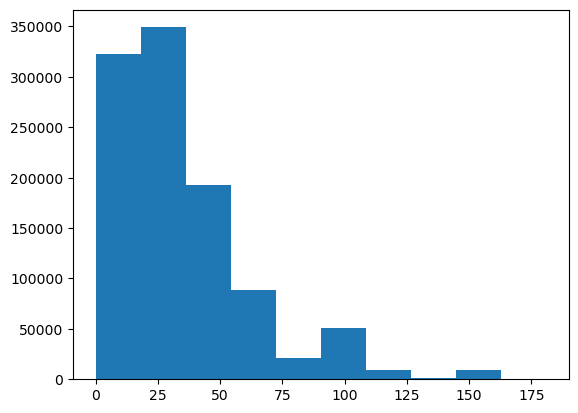

In [39]:
plt.hist(avg_pars)

(array([6.99144e+05, 2.15282e+05, 8.56970e+04, 2.88400e+04, 8.42600e+03,
        5.32500e+03, 7.33000e+02, 1.22800e+03, 5.08000e+02, 1.30000e+01]),
 array([  0.,  34.,  68., 102., 136., 170., 204., 238., 272., 306., 340.]),
 <BarContainer object of 10 artists>)

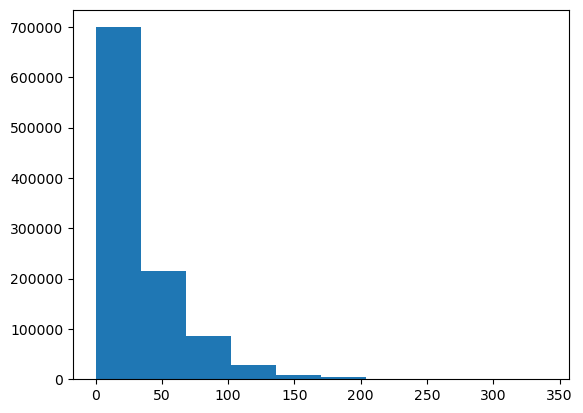

In [40]:
plt.hist(chosen_pars)

In [36]:
from scipy import stats
stats.ttest_ind(chosen_pars,avg_pars)

Ttest_indResult(statistic=-108.12216514780872, pvalue=0.0)

#### Visualizations

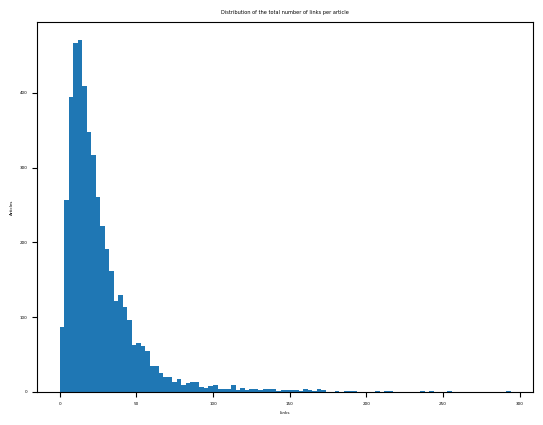

In [43]:
links_counts = wiki_graph["links_count"].values

plt.hist(links_counts, bins=100)
plt.title("Distribution of the total number of links per article")
plt.xlabel("Links")
plt.ylabel("Articles")
plt.show()

                                    article
category                                   
subject.Art.Art                          36
subject.Art.Artists                       2
subject.Business_Studies.Business        28
subject.Business_Studies.Companies       18
subject.Business_Studies.Currency        14


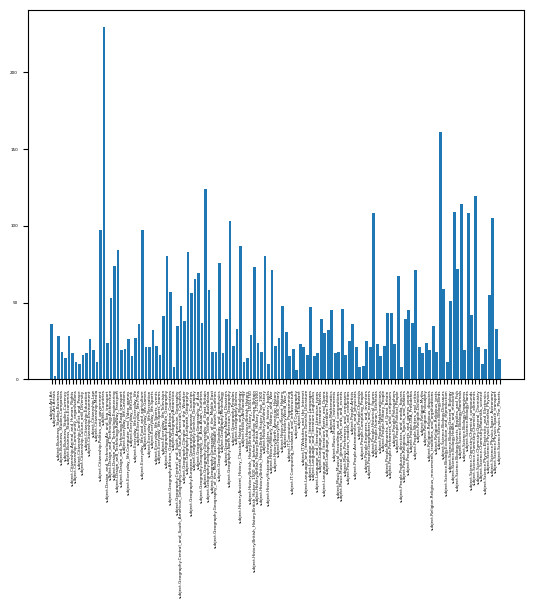

In [44]:
groups = categories.groupby("category").count()

print(groups.head())

labels = list(groups.index)
values = list(groups["article"])

X_axis = np.arange(len(labels))

plt.rcParams["font.size"] = "3"

plt.xticks(rotation=90)
plt.bar(labels, values)
plt.show()

In [45]:
def sort_dict_by_value(dict):
    return sorted(dict.items(), key=lambda x: x[1], reverse=True)


In [73]:
wiki_graph[wiki_graph["article"] == "Badugi"]
articles[articles["article"] == "Badugi"]

,article
441,Badugi


Badugi
??
2684
11673
442


KeyboardInterrupt: 

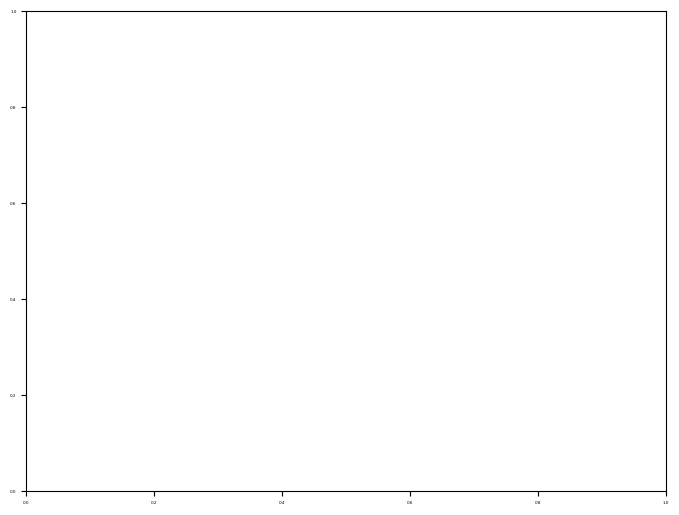

In [69]:
G = nx.Graph()

sampled_wiki_graph = wiki_graph#.sample(100, replace=False)
counter = 0
for ind in sampled_wiki_graph.index:
    counter +=1
    node_name = wiki_graph["article"][ind]
    node_links = wiki_graph["links"][ind]
    if(len(node_links) == 0):
        print(node_name)
        print("??")
        break
    for l in node_links:
        G.add_edge(node_name, l)

print(G.number_of_nodes())
print(G.number_of_edges())
print(counter)

nx.draw(G, with_labels=False, node_size=0.1)
plt.draw()
plt.savefig("wikispeedia_graph.pdf")

In [47]:
# graph analytics
pagerankDict = nx.pagerank(G, alpha=0.9)

topN = 10
top_tuples = sort_dict_by_value(pagerankDict)[:topN]
for (key,value) in top_tuples:
    print(key,"->",value)

United_States -> 0.0073487693403575405
United_Kingdom -> 0.00458076938779606
Europe -> 0.004353391538443455
France -> 0.004157386167202908
England -> 0.0036954152923990924
Germany -> 0.0033470404654848645
World_War_II -> 0.003344467147522731
Scientific_classification -> 0.0028688381329989134
London -> 0.0028377288959734394
English_language -> 0.0027092009622877904


In [63]:
print(len(list(nx.connected_components(G))[1]))
print(len(list(nx.connected_components(G))[0]))
print(G.number_of_nodes())

3
4589
4592


## Analyze the paths

In [ ]:
def quantize_path(str_path):
    return str_path.split(";")

def get_start_node(list_path):
    return list_path[0]

def get_target_node(list_path):
    return list_path[len(list_path)-1]

In [ ]:
paths_finished = pd.read_csv(
    "data/graph/paths_finished.tsv",
    skiprows=15,
    sep="\t",
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating", "status","start", "target"],
)

paths_finished["status"] = ["Success" for x in range(len(paths_finished.index))]
#paths_finished["type"] = ["Success" for x in range(len(paths_finished.index))]

paths_finished["path"] = paths_finished["path"].apply(quantize_path)
paths_finished["start"] = paths_finished["path"].apply(get_start_node)
paths_finished["target"] = paths_finished["path"].apply(get_target_node)

paths_finished = paths_finished.drop(columns=["hashedIpAddress", "timestamp"])

paths_finished.tail()

,durationInSec,path,rating,status,start,target
51313,66,"[Yagan, Ancient_Egypt, Civilization]",NaN,Success,Yagan,Civilization
51314,165,"[Yagan, Folklore, Brothers_Grimm, <, 19th_cent...",3.0,Success,Yagan,Fiction
51315,228,"[Yagan, Australia, England, France, United_Sta...",NaN,Success,Yagan,U.S._Open_%28tennis%29
51316,56,"[Yarralumla%2C_Australian_Capital_Territory, A...",1.0,Success,Yarralumla%2C_Australian_Capital_Territory,Abraham_Lincoln
51317,30,"[Ziad_Jarrah, Germany, Jew]",NaN,Success,Ziad_Jarrah,Jew


In [ ]:
paths_unfinished = pd.read_csv(
    "data/graph/paths_unfinished.tsv",
    skiprows=19,
    sep="\t",
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"],
)

paths_unfinished = paths_unfinished.drop(columns=["hashedIpAddress", "timestamp"])

paths_unfinished["status"] = ["Fail" for x in range(len(paths_unfinished.index))]
#paths_unfinished["rating"] = [-999 for x in range(len(paths_unfinished.index))]

paths_unfinished["path"] = paths_unfinished["path"].apply(quantize_path)
paths_unfinished["start"] = paths_unfinished["path"].apply(get_start_node)

#Should we drop timeouts?
paths_unfinished = paths_unfinished[paths_unfinished["type"] != "timeout"]

paths_unfinished.head()

,durationInSec,path,target,type,status,start
1,49,[Paraguay],Mount_St._Helens,restart,Fail,Paraguay
5,175,"[4-2-0, United_States, Agriculture, Sugar, Aus...",Cane_Toad,restart,Fail,4-2-0
6,19,[Logic],Moon_landing,restart,Fail,Logic
9,8,[Niobium],Beeching_Axe,restart,Fail,Niobium
10,334,"[Saint_Kitts_and_Nevis, United_Kingdom, World_...",Sandy_Koufax,restart,Fail,Saint_Kitts_and_Nevis


In [ ]:
red_paths_finished = paths_finished.drop(columns=["rating"])
red_paths_unfinished = paths_unfinished.drop(columns=["type"])

paths = pd.concat([red_paths_finished,red_paths_unfinished],axis=0).drop(columns=["durationInSec"])

paths = paths.reindex(columns=["start","target","status","path"])

paths.tail()

,start,target,status,path
24866,Wine,History_of_post-Soviet_Russia,Fail,"[Wine, Georgia_%28country%29, Russia]"
24867,Turks_and_Caicos_Islands,Iraq_War,Fail,"[Turks_and_Caicos_Islands, United_States, Iraq..."
24868,Franz_Kafka,Cholera,Fail,"[Franz_Kafka, Tuberculosis, World_Health_Organ..."
24869,Modern_history,Hollandic,Fail,[Modern_history]
24872,Mark_Antony,Feather,Fail,"[Mark_Antony, Rome, Tennis, Hawk-Eye, Computer]"


In [ ]:
paths = pd.DataFrame(columns=["start", "path", "target", "failed", "rating", "type", "hashedIpAddress", "timestamp", "durationInSec"])
paths.head()

,start,path,target,failed,rating,type,hashedIpAddress,timestamp,durationInSec
